In [1]:
import xarray as xr
import rioxarray as rioxr

import geopandas as geopd
import pandas as pd

import numpy as np

import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

In [5]:
root = "/media/iiro/T9/finland_climate/fmi_grid_download"

dirs = ['RRday', 'ET0_FAO', 'Tday',
        'Tgmin', 'Tmin', 'Tmax',
        'Rh', 'Globrad']
# Converting from FMI namespace to CAMELS
attributes = {'Rh' : 'humidity' ,'ET0_FAO': 'pet', 'Tday': 'temperature_mean',
              'Tmin': 'temperature_min', 'Tgmin': 'temperature_gmin', 'Tmax': 'temperature_max',
              'RRday': 'precipitation', 'Globrad': 'radiation_global'}
dst_dir = "/media/iiro/T9/CAMELS-FI/data/timeseries"

if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

years = (1990, 1991)

weather = pd.DataFrame(columns=['date'] + dirs, index=pd.to_datetime([]))
pbar = tqdm(range(len(watersheds)))
for i in pbar:
    watershed = watersheds.loc[[i]]
    place_id = watershed.at[i, 'Paikka_Id']
    # Constructing the path of the timeseries for this catchment
    path = os.path.join(dst_dir, f"CAMELS_FI_hydromet_timeseries_{place_id}_{years[0]}0101-{years[1]}1231.csv")
    for current_dir in dirs:
         
        for year in range(years[0], years[1] + 1):
            # Evapotranspiration has differing scheme to all other sources
            if current_dir == 'ET0_FAO':
                file_name = f"{current_dir}_{year}_months_4_to_9.nc"
            else:
                file_name = f"{current_dir.lower()}_{year}.nc"
            src_path = os.path.join(root, current_dir, file_name)
            
            assert os.path.exists(src_path), f"path {src_path} doesn't exists"
            
            with rioxr.open_rasterio(src_path, mask_and_scale=True) as src:
                data_array = src.copy()
    
            # Iterating over the days
            for time_step in data_array.Time:
                time = time_step.item()
                pbar.set_description(f"Processing watershed {place_id:>4}, {attributes[current_dir]:>16}, {year}, {str(time)[0:10]}")
                
                one_day_data = data_array.sel({'Time':time})

                # Calculating the average of the attribute for the whole catchment
                clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs)
                average = clipped.mean().item()
                # Failsafe for catchments smaller than the pixel size
                if average is np.nan:
                    print(f"catchment {i} was too small")
                    clipped = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=true)
                    average = clipped.mean().item()

                    assert average is not np.nan, f"no data for the catchment{i}, variable {current_dir}"
                
                # turning cftime to str helps pandas parse it as datetime index
                weather.loc[str(time), 'date'] = pd.to_datetime(str(time)).date()
                weather.loc[str(time), attributes[current_dir]] = average
                

    weather.to_csv(path)
                
                
            
        
    break
    

  0%|          | 0/166 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: >

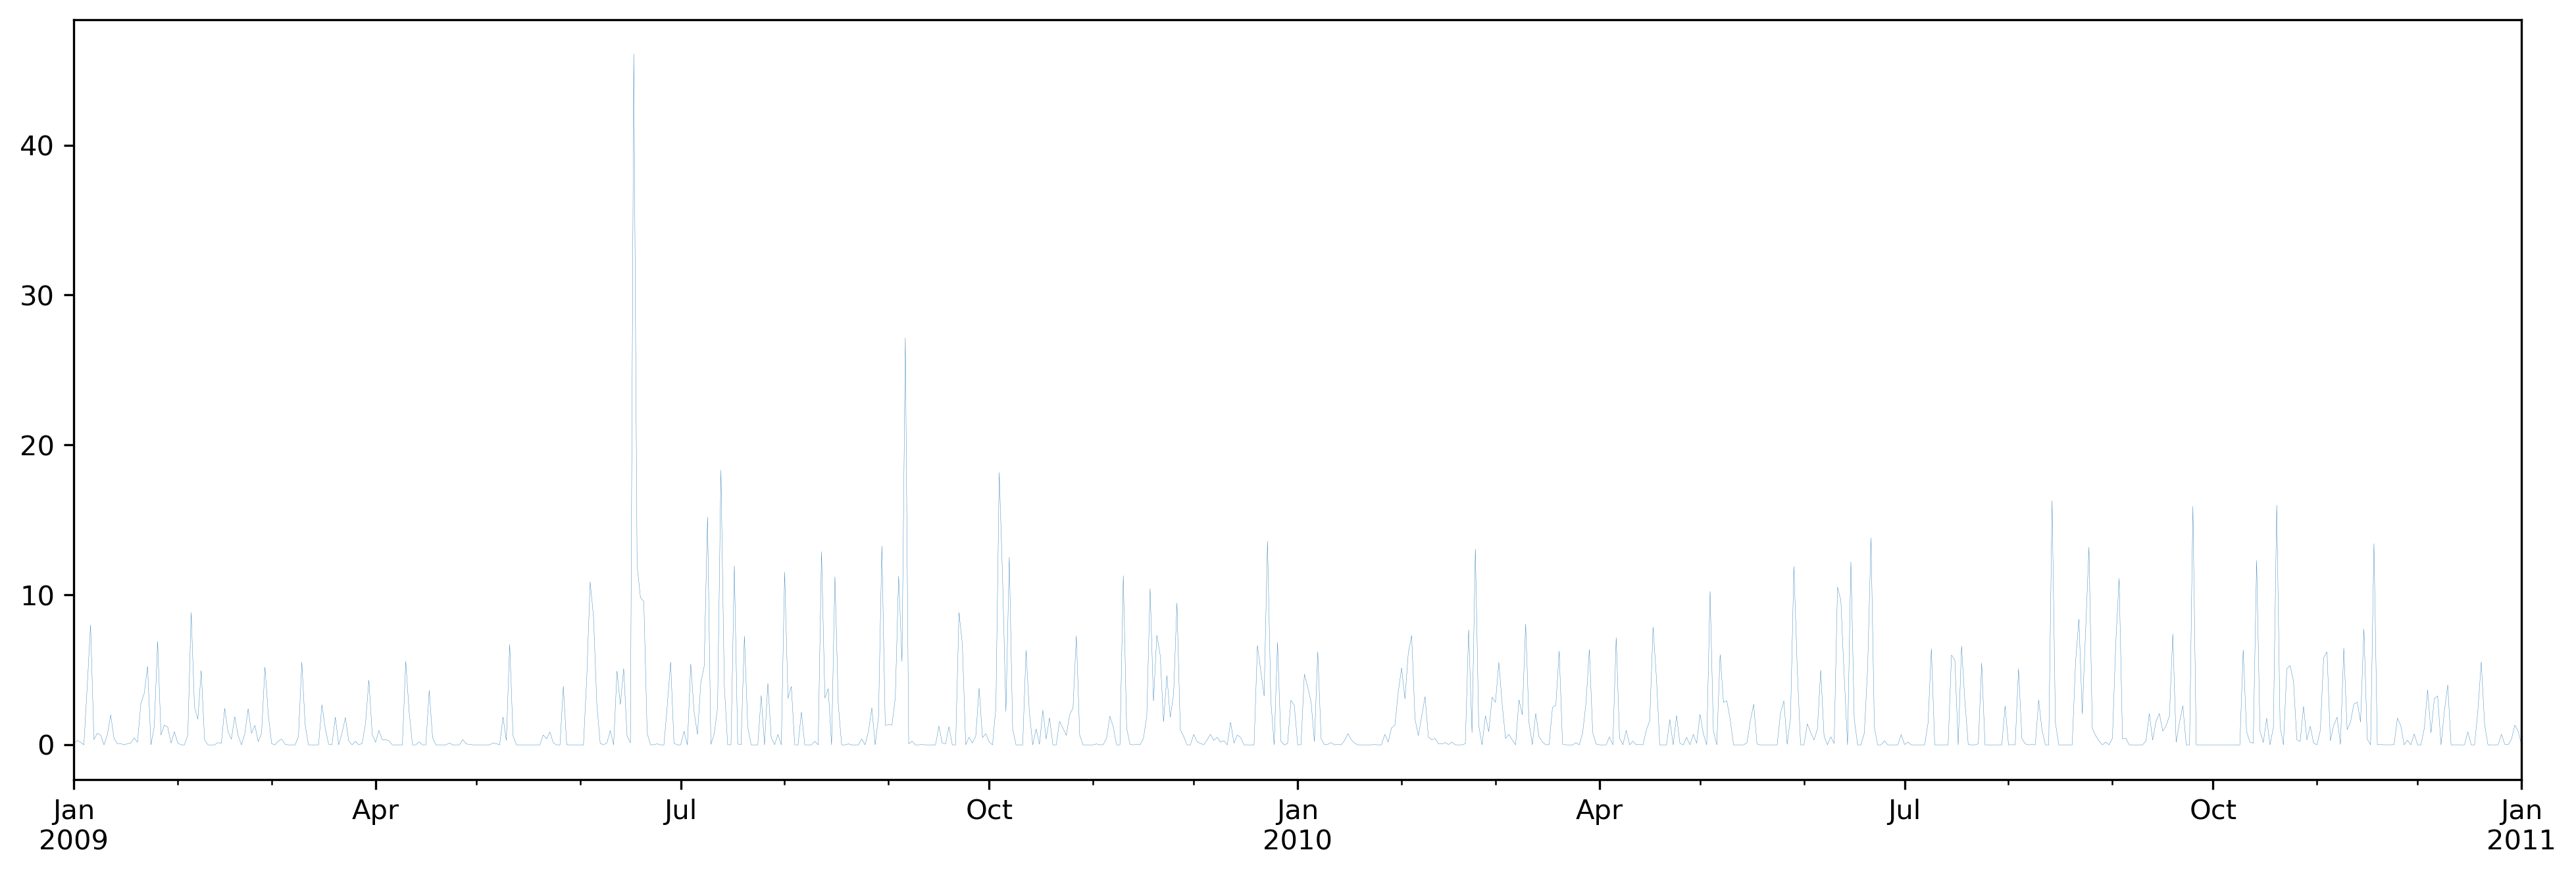

In [15]:
weather['precipitation'].plot.line(linewidth=0.1, figsize=(16, 5), xlim=("20090101", "20110101"))

1.7423689365386963


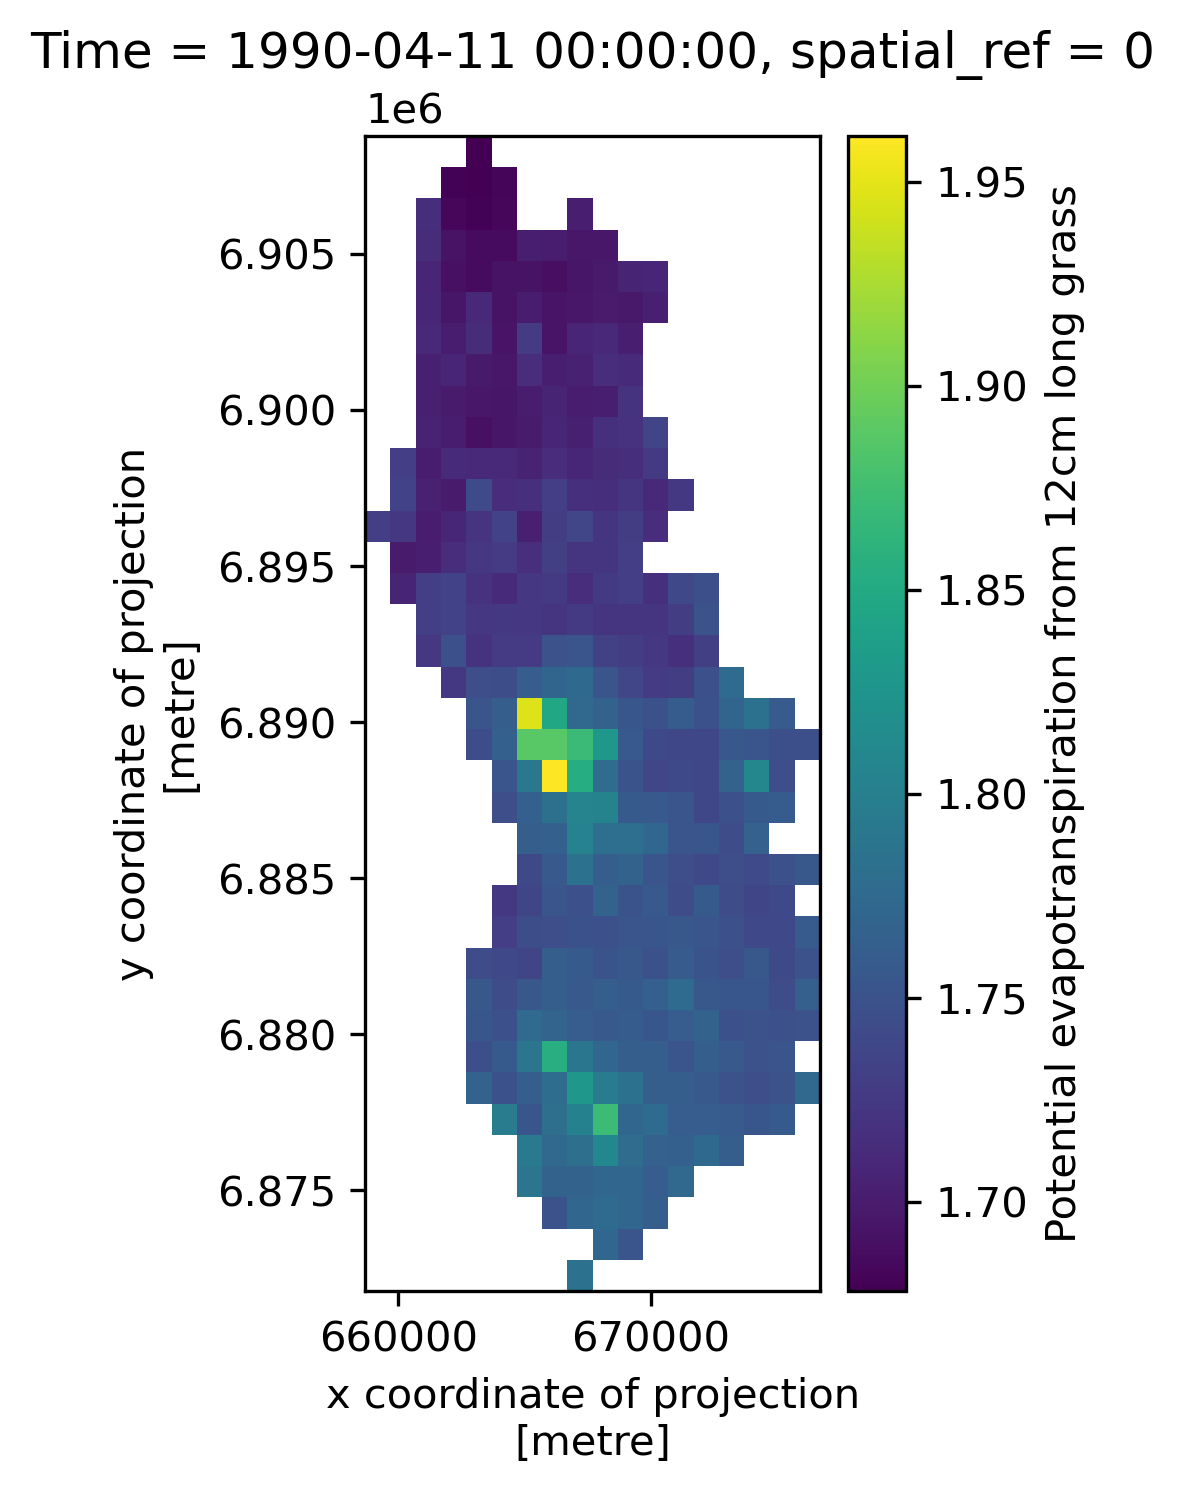

In [10]:
bounds = watershed.bounds
minx = bounds.at[i, 'minx']
maxx = bounds.at[i, 'maxx']
miny = bounds.at[i, 'miny']
maxy = bounds.at[i, 'maxy']
aspect = (maxx-minx) / (maxy-miny)
print(one_day_data.rio.clip(watershed.geometry.values).mean().item())
qm = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs).plot(aspect=aspect, size=5, cbar_kwargs={'label': one_day_data.long_name})

In [8]:
weather

,date,ET0_FAO,Globrad,Rh,RRday,Tday,Tmin,Tmax
1990-04-01,1990-04-01,1.544164,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-02,1990-04-02,0.952998,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-03,1990-04-03,0.584674,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-04,1990-04-04,1.016381,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-05,1990-04-05,0.83944,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-06,1990-04-06,0.602331,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-07,1990-04-07,0.698918,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-08,1990-04-08,0.724545,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-09,1990-04-09,1.386968,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-10,1990-04-10,1.620269,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len('temperature_gmin')

16

In [6]:
data_array.dims

('Time', 'y', 'x')

In [97]:
weather = pd.DataFrame(columns=['date'] + dirs, index=pd.to_datetime([]))

In [107]:
weather.loc[str(time), 'ET0_FAO'] = 1

In [112]:
pd.to_datetime(str(time)).date()

datetime.date(1994, 4, 1)

In [106]:
pd.to_datetime(str(time))

Timestamp('1994-04-01 00:00:00')

In [8]:
for time_step in data_array.Time:
    time = time_step.item()
    
    break

In [9]:
#one_day_data = data_array.sel({'Time':'1994-04-01'})
one_day_data = data_array.sel({'Time':time})
#one_day_data.write_nodata(np.nan, inplace=True)


In [91]:
clipped = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs)

0.9074239730834961


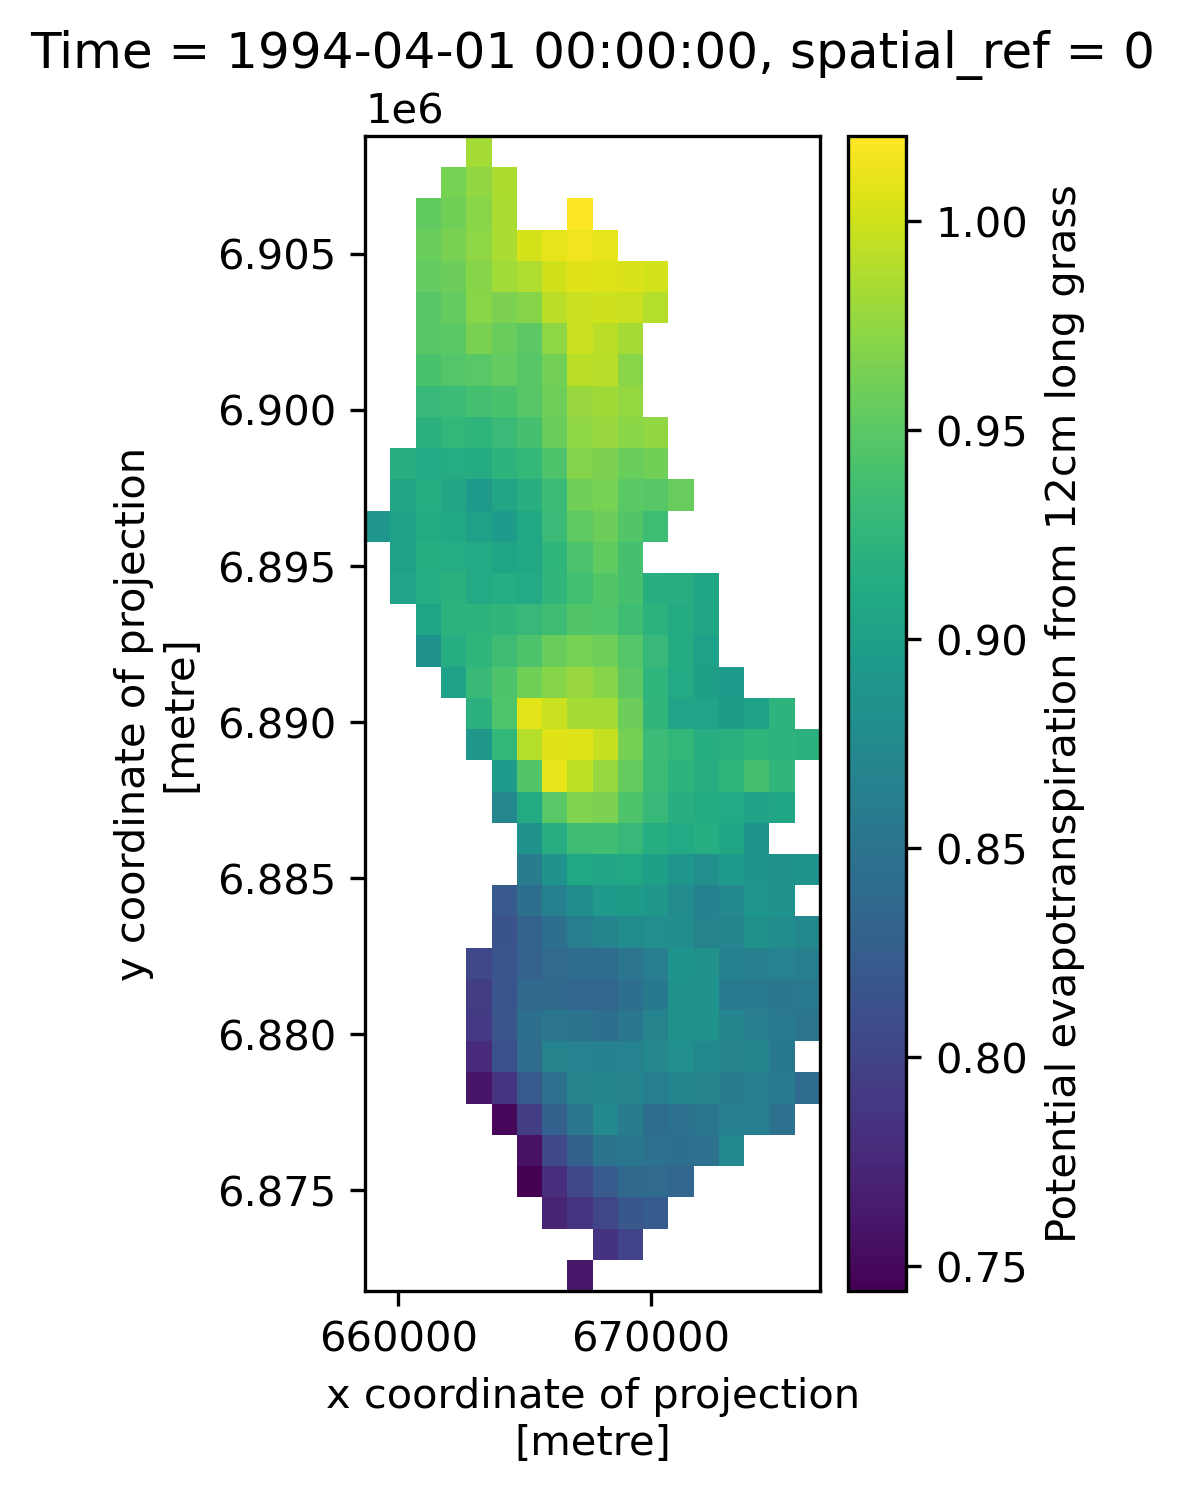

In [90]:
"""
geometries = [
    {
        'type':'Polygon',
        'coordinates': [[
            [300_000, 6_800_000],
            [400_000, 6_800_000],
            [400_000, 7_000_000],
            [350_000, 6_900_000],
            [300_000, 7_000_000]
        ]]
    }
]
"""
i = 0
watershed = watersheds.loc[[i]] 
bounds = watershed.bounds
minx = bounds.at[i, 'minx']
maxx = bounds.at[i, 'maxx']
miny = bounds.at[i, 'miny']
maxy = bounds.at[i, 'maxy']
aspect = (maxx-minx) / (maxy-miny)
print(one_day_data.rio.clip(watershed.geometry.values).mean().item())
qm = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs).plot(aspect=aspect, size=5, cbar_kwargs={'label': one_day_data.long_name})

In [69]:
one_day_data.long_name

'Potential evapotranspiration from 12cm long grass'

<Axes: >

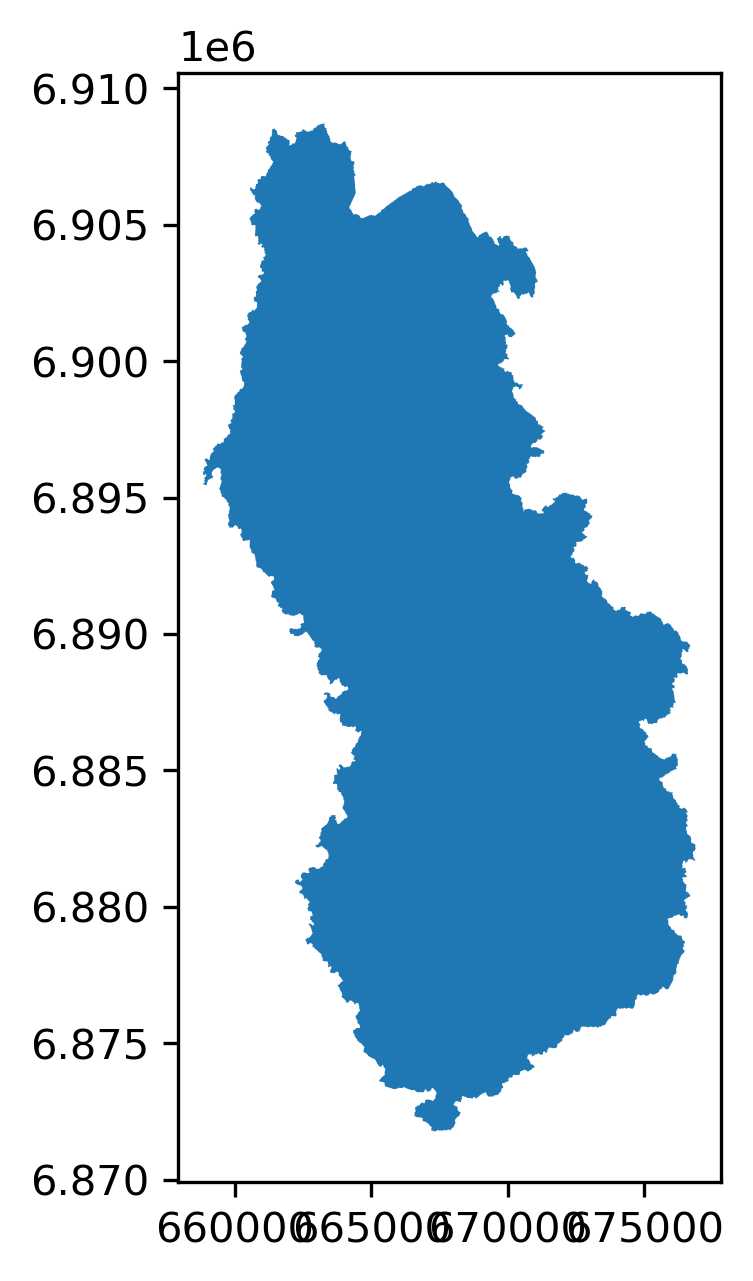

In [89]:
watershed.plot()

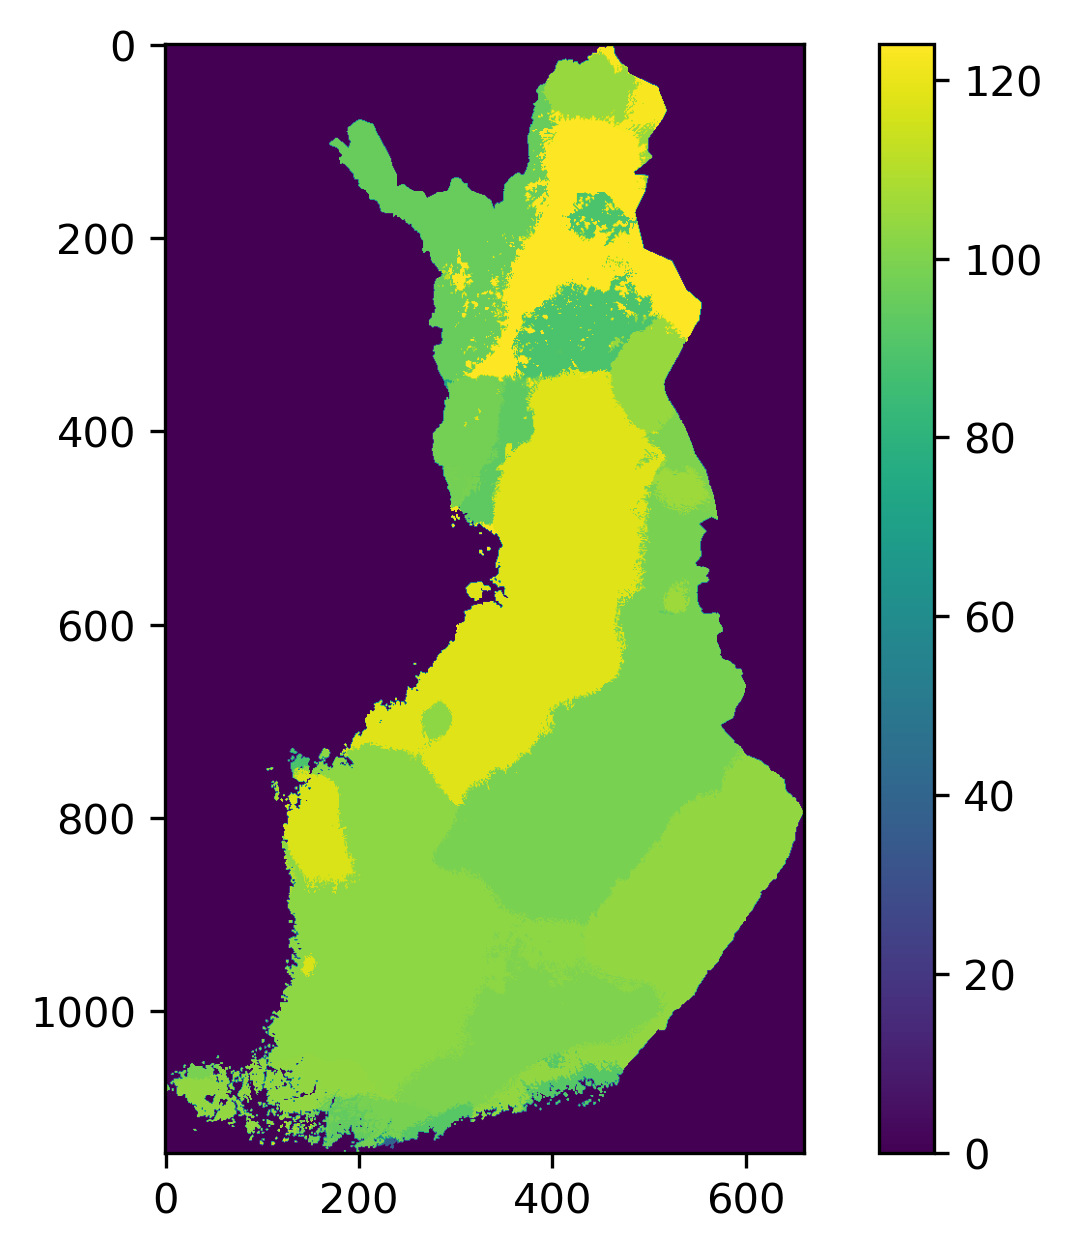

In [36]:
im = plt.imshow(data_array.argmax('Time'))
cbar = plt.colorbar(im)

In [59]:
print(data_array.x.to_numpy().min(), data_array.x.to_numpy().max())

73189.8723 733189.8723
